In [40]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import torch
import matplotlib.pyplot as plt

x_dim = 4096
y_dim = 4096
x_bits = 7000
y_bits = 7000
N = 20
X = np.random.randn(x_dim, N)
A= np.random.randn(y_dim,x_dim)
Y= A@X

X.shape, Y.shape

((4096, 20), (4096, 20))

In [41]:
def random_projection(size,dist='normal', normalize=False, bias=False, scale=1, gate=False):
    
    # sample from a family of distribution
    if dist =='laplace':
        dist = torch.distributions.laplace.Laplace(0, 1)
    elif dist =='bernoulli':
        dist = torch.distributions.bernoulli.Bernoulli(0.5)
    elif dist =='uniform':
        dist = torch.distributions.uniform.Uniform(-1,1)
    else:
        dist = torch.distributions.normal.Normal(0,1)

    x = dist.sample(size)
    
    # normalize for unit-norm
    if bias or normalize:
        x = torch.nn.functional.normalize(x,dim=-1)

    # if bias (via quantile plans)    
    if bias:
        dist = torch.distributions.beta.Beta(1,1)
        b = dist.sample((size[1],))
        x = x + b

    if scale is not None:
        x = scale*x
    
    # quantize. tanh scale 
    if gate:
        x = torch.tanh(x)

    x = x.detach().numpy()
    return x

x = random_projection((2,3),dist='laplace',normalize=True,bias=True,scale=5,gate=True)

In [42]:
def activation(x, func=None):
    if func == 'sign':
        x = np.sign(x)
    elif func == 'heavy':
        x = np.np.heaviside(x,0)
    elif func == 'tanh':
        x = np.tanh(x)
    else:
        pass
    return x

In [43]:
dist = 'uniform'
bias=False
gate=False
normalize=True
scale=1
act='tanh'


In [44]:

Phi_X = random_projection((x_bits,x_dim),dist=dist,bias=bias,gate=gate, normalize=normalize)
Phi_Y = random_projection((y_bits,y_dim),dist=dist,bias=bias,gate=gate, normalize=normalize)
print(Phi_X.shape)
print(Phi_Y.shape)

(7000, 4096)
(7000, 4096)


In [45]:
x_binary = activation(Phi_X@X,func=act)
y_binary = activation(Phi_Y@Y,func=act)
print(x_binary.shape)
print(y_binary.shape)


(7000, 20)
(7000, 20)


(array([[1034.,  784.,  637.,  589.,  563.,  565.,  534.,  607.,  723.,
          964.],
        [ 960.,  760.,  616.,  577.,  563.,  583.,  588.,  682.,  746.,
          925.],
        [ 997.,  782.,  676.,  583.,  557.,  524.,  588.,  622.,  745.,
          926.],
        [ 970.,  738.,  608.,  574.,  584.,  569.,  573.,  656.,  762.,
          966.],
        [ 957.,  753.,  683.,  588.,  557.,  571.,  548.,  626.,  799.,
          918.],
        [ 998.,  730.,  628.,  613.,  594.,  541.,  561.,  642.,  736.,
          957.],
        [ 865.,  801.,  617.,  562.,  614.,  626.,  601.,  652.,  729.,
          933.],
        [ 973.,  754.,  653.,  531.,  561.,  538.,  559.,  639.,  789.,
         1003.],
        [ 994.,  796.,  648.,  582.,  557.,  519.,  558.,  606.,  736.,
         1004.],
        [ 933.,  762.,  684.,  578.,  589.,  543.,  579.,  645.,  729.,
          958.],
        [ 923.,  749.,  719.,  587.,  561.,  566.,  592.,  601.,  745.,
          957.],
        [ 972.,  731.

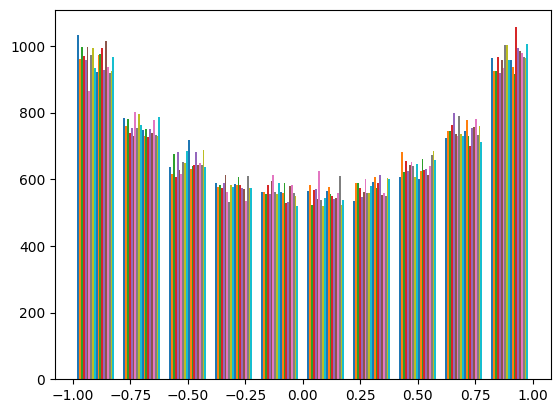

In [46]:
plt.hist(x_binary)

In [47]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)
sqrt_S = np.sqrt(S)# Compute sqrt of sigma to adjust in U and Vt

# Form the Values before projection
U_s = U @ np.diag(sqrt_S)# Adjust sigma in U and Vt
#U_s =  U

# Form the Keys before projection
V_s = Vt.T @ np.diag(sqrt_S)# Adjust sigma in Vt
#V_s = Vt.T


In [48]:
def elu(x, alpha=1.0):
    """
    Computes the Exponential Linear Unit (ELU) activation function.

    Parameters:
        x (array-like): Input data (scalar, vector, or matrix).
        alpha (float): The alpha parameter controlling the saturation for x <= 0. Default is 1.0.

    Returns:
        np.ndarray: Transformed data after applying the ELU activation.
    """
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def softmax(x):
    """
    Compute the softmax of vector x.
    
    Parameters:
    x (numpy.ndarray): Input array.
    
    Returns:
    numpy.ndarray: Output array after applying softmax.
    """
    # Subtract the max value from x for numerical stability
    #x_max = np.max(x, axis=-1, keepdims=True)
    #e_x = np.exp(x - x_max)
    eps = 0.001
    e_x = np.exp(x)+eps
    z = np.sum(e_x)
    return e_x / z

In [49]:
Values = activation(Phi_Y@ U_s,func=act)
Keys = activation(Phi_X@ V_s,func=act)

c = [0,0.5,-0.5]
x_query = c[0]*V_s[:,0].reshape(-1,1) + c[1]*V_s[:,1].reshape(-1,1) + c[2]*V_s[:,1024].reshape(-1,1)
x_query = x_query/np.linalg.norm(x_query)

x_query_bits = activation( Phi_X@x_query,func=act) 

y_true = A@x_query

attn = Keys.T@x_query_bits.reshape(-1,1)
elu_attn = softmax(attn/np.sqrt(512))
elu_attn = attn

y_true_bits = activation( Phi_Y@y_true,func=act)
y_true_bits_hat =  activation( (Values@elu_attn),func=act)



y_true_hat =  U@elu_attn
y_true_hat = y_true_hat/np.linalg.norm(y_true_hat)
y_true = y_true/np.linalg.norm(y_true)

print('Dense recon. R2: ',1-(np.linalg.norm(y_true_hat-y_true)/np.linalg.norm(y_true)))
print('bitwise accuracy',100*np.sum(y_true_bits_hat==y_true_bits)/len(y_true_bits_hat))
print('Bits recon. R2: ',1-(np.linalg.norm(y_true_bits-y_true_bits_hat)/np.linalg.norm(y_true_bits)))
print('cosine sim: ',)

Dense recon. R2:  0.4979846778885403
bitwise accuracy 0.0
Bits recon. R2:  0.42848175910451425
cosine sim: 


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
print(y_true_bits_hat.shape)
print(y_true_bits.shape)
print('Bits cosine sim.: ',cosine_similarity(y_true_bits_hat.T,y_true_bits.T))
print('Dense cosine sim.: ',cosine_similarity(y_true_hat.T,y_true.T))


(7000, 1)
(7000, 1)
Bits cosine sim.:  [[0.86293571]]
Dense cosine sim.:  [[0.87399031]]


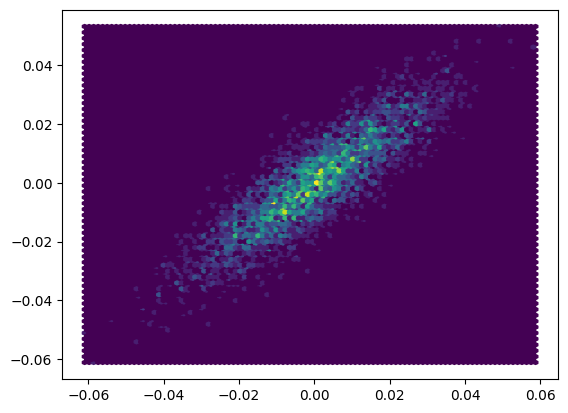

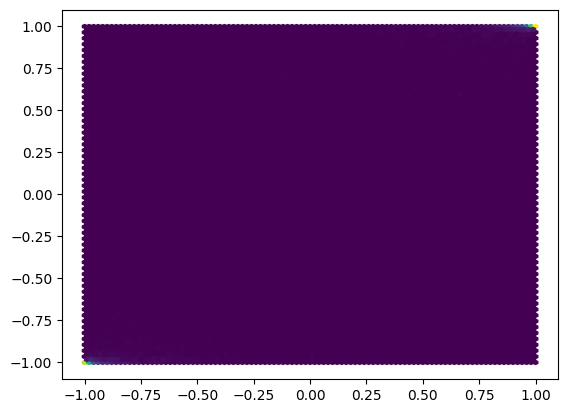

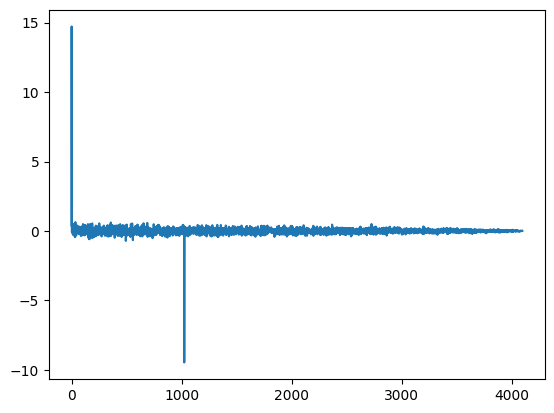

In [51]:
import matplotlib.pyplot as plt
plt.hexbin(y_true, y_true_hat)
plt.show()
plt.hexbin(y_true_bits, y_true_bits_hat)
plt.show()
plt.plot(elu_attn)